In [1]:
%matplotlib inline
%pylab inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import copy
import csv
from collections import OrderedDict

import xgcm


from dask.distributed import Client
import climtas.nci

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib
Available exptdata keys:  ['1deg_c1', '025deg_c1', '01deg_c1', '1deg_c2', '025deg_c2', '01deg_c2', '1deg_c3', '025deg_c3', '01deg_c3']


In [2]:
import climtas.nci
climtas.nci.GadiClient(malloc_trim_threshold='64kib')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42845,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:42729,Total threads: 1
Dashboard: /proxy/34863/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:44425,


In [3]:
session = cc.database.create_session()

In [4]:
data = copy.deepcopy(exptdata.exptdict) 

In [5]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight", facecolor = 'w')  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

# Parameters


In [6]:
rho=1025 # kg/m^3
Ω = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m

# Useful function

In [7]:
def wcoast(island):
    ''' return boolean array that is 1 only on island's west coast '''
    islandwcoast = xr.full_like(island, False)
    islandwcoast[:,0:-2] = ((~island[:,0:-2].data) & (island[:,1:-1].data))
    return islandwcoast

In [8]:
def findcoast(row):
    ''' return index of first 1 value, or nan if none found '''
    try:
        return row.index(1) 
    except ValueError:
        return np.nan

In [9]:
def coasti(wcoast):
    ''' return i index of westernmost 1 at each latitude '''
    js = list(range(wcoast.data.shape[0]))
    return [ findcoast(x) for x in [ list(wcoast.isel(yu_ocean=j).data) for j in js ] ]

In [10]:
# Sverdrup transport without Tasman Sea
def Sverdrup_transport(ζ_xgcm):

    island0 = islands[0]  
    islandwcoast = wcoast(island0).load()
    WBi0 = coasti(islandwcoast)
    WB0 = [ -1e10 if np.isnan(i) else lons[i].item() for i in WBi0 ]
    WB0 = np.array(WB0).reshape((-1, 1))
    
    island1 = islands[1]  
    islandwcoast = wcoast(island1).load()
    WBi1 = coasti(islandwcoast)
    WB1 = [ 1e10 if np.isnan(i) else lons[i].item() for i in WBi1 ]
    WB1 = np.array(WB1).reshape((-1, 1))
    
    lWB0 = np.tile(WB0, len(lons))
    lWB1 = np.tile(WB1, len(lons))
    llons = np.tile(lons.data, (len(lats),1))

    irregion=(llons>=lWB1) & (llons<=lWB0)
    IRregion = xr.full_like(islandwcoast, False)
    IRregion[:] = irregion
    IRregion = IRregion.astype(bool)
    

    ζ_xgcm = ζ_xgcm.fillna(0)
    ζ_xgcm = ζ_xgcm.sel(xu_ocean=slice(-220,-70)).sel(yu_ocean=slice(-49,-3.5))
                                                         
    # plt.figure()
    # IRregion.plot(figsize=(25,8))

    beta=2*Ω *np.cos(np.deg2rad(lats))/Rearth
    dxu = (diff(lons)[0])*Rearth*2*pi/360*np.cos(np.deg2rad(lats))
    
    ST = np.flip(np.flip(ζ_xgcm).cumsum('xu_ocean')*dxu/rho/beta/1e6)
    ST = ST * (~IRregion)     # remove the Tasman Sea
    ST = ST.rename('ST value')
    ST.attrs['long_name'] = 'Sverdrup transport value'
    ST.attrs['units'] = 'Sv'
    
    return  -ST

In [11]:
# # Sverdrup transport for Tasman Sea
# def Sverdrup_transport_T(ζ_xgcm):

#     island0 = islands[0]  
#     islandwcoast = wcoast(island0).load()
#     WBi0 = coasti(islandwcoast)
#     WB0 = [ -1e10 if np.isnan(i) else lons[i].item() for i in WBi0 ]
#     WB0 = np.array(WB0).reshape((-1, 1))
    
#     island1 = islands[1]  
#     islandwcoast = wcoast(island1).load()
#     WBi1 = coasti(islandwcoast)
#     WB1 = [ 1e10 if np.isnan(i) else lons[i].item() for i in WBi1 ]
#     WB1 = np.array(WB1).reshape((-1, 1))
    
#     lWB0 = np.tile(WB0, len(lons))
#     lWB1 = np.tile(WB1, len(lons))
#     llons = np.tile(lons.data, (len(lats),1))

#     irregion=(llons>=lWB1) & (llons<=lWB0)
#     IRregion = xr.full_like(islandwcoast, False)
#     IRregion[:] = irregion
#     IRregion = IRregion.astype(bool)
    
#     ζ_xgcm = ζ_xgcm * (IRregion) # only for Tasman Sea
#     ζ_xgcm = ζ_xgcm.fillna(0)
#     ζ_xgcm = ζ_xgcm.sel(xu_ocean=slice(-220,-70)).sel(yu_ocean=slice(-49,-3.5))
                                                         
#     # plt.figure()
#     # IRregion.plot(figsize=(25,8))

#     beta=2*Ω *np.cos(np.deg2rad(lats))/Rearth
#     dxu = (diff(lons)[0])*Rearth*2*pi/360*np.cos(np.deg2rad(lats))
    
#     ST = np.flip(np.flip(ζ_xgcm).cumsum('xu_ocean')*dxu/rho/beta/1e6) - ir_nz*(IRregion)
#     ST = ST.rename('ST value')
#     ST.attrs['long_name'] = 'Sverdrup transport value'
#     ST.attrs['units'] = 'Sv'
    
#     return  -ST

## Dictionary

In [11]:
folder = {'1deg_c1': '/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle1/output000/ocean/ocean_grid.nc',
          '025deg_c1': '/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1/output000/ocean/ocean_grid.nc',
          '01deg_c1': '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/',
          
          '1deg_c2': '/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle2/output061/ocean/ocean_grid.nc',
          '025deg_c2': '/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle2/output061/ocean/ocean_grid.nc',
          '01deg_c2': '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle2/output244/ocean/',
          
          '1deg_c3': '/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle3/output122/ocean/ocean_grid.nc',
          '025deg_c3': '/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle3/output122/ocean/ocean_grid.nc',
          '01deg_c3': '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output488/ocean/'}

### EAC Sverdrup transport

In [14]:
%%time

a = []

for i, ekey in enumerate(data.keys()):
    print(ekey)
    
    e = data[ekey]
    
    # devide time interval
    b = []
    c = []
    
    # dataset1 = pd.read_csv('3.2 IR_value/IR_NZ(1).csv')
    # IR_NZ = dataset1.iloc[:, i+1].values
    
    for j, t in enumerate(range (58,119,1)):
        tstart = pd.to_datetime('1900/01/01') + pd.DateOffset(years=t)
        tend   = tstart + pd.DateOffset(years=1)
        print(str(tstart) +'-'+str(tend))
        
        c.append(str(tstart.year) +'-'+str(tend.year))
         
            
        # load data for each time interval
        expt = data[ekey]['expt']
        
        u = cc.querying.getvar(expt,'u',session,
                               frequency = '1 monthly',
                               start_time='1958-01-01 00:00:00', 
                               end_time='1958-03-01 00:00:00').isel(time=0).sel(st_ocean=0,method='nearest')
        tau_x = cc.querying.getvar(expt, variable='tau_x', 
                                  session=session, frequency='1 monthly',
                                  start_time=str(tstart.year), 
                                  end_time=str(tend.year)).sel(time=slice(tstart,tend)).mean('time').compute()
        tau_y = cc.querying.getvar(expt, variable='tau_y', 
                                  session=session, frequency='1 monthly',
                                  start_time=str(tstart.year), 
                                  end_time=str(tend.year)).sel(time=slice(tstart,tend)).mean('time').compute()
        
        lons = u.xu_ocean
        lats = u.yu_ocean
        
        
        if (i+1)%3 == 0:
            grid1 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dxt.nc', combine='by_coords')
            grid2 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dyt.nc', combine='by_coords')
            grid3 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dxu.nc', combine='by_coords')
            grid4 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dyu.nc', combine='by_coords')
            ds = xr.merge([tau_x, tau_y, grid1, grid2, grid3, grid4])

        else:
            grid = xr.open_mfdataset(folder[ekey], combine='by_coords')
            ds = xr.merge([tau_x, tau_y, grid])
            
        ds.coords['xt_ocean'].attrs.update(axis='X')
        ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
        ds.coords['yt_ocean'].attrs.update(axis='Y')
        ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
        
        grid = xgcm.Grid(ds, periodic=['X'])
        
        
        # ζ_xgcm = ( grid.interp( grid.diff(ds.tau_y, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
        #   - grid.interp( grid.diff(ds.tau_x, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )
        
        ζ_xgcm = (grid.interp( grid.diff(ds.tau_y, 'X') / grid.interp(ds.dxu, 'X'), 'X') 
             -  grid.interp( grid.diff(ds.tau_x, 'Y', boundary='extend') / grid.interp(ds.dyu, 'Y', boundary='extend'), 'Y', boundary='extend'))

        ζ_xgcm = ζ_xgcm.rename('Wind stress curl')
        ζ_xgcm.attrs['long_name'] = 'Wind stress curl, ∂τy/∂x-∂τx/∂y'
        ζ_xgcm.attrs['units'] = 'N m$^{-3}$'
        
        
        # land mask
    
        Aus1 = np.isnan(u).where(lons>=-248,other=False).where(lons<=-205,other=False).where(lats>=-45,other=False).where(lats<=3.5,other=False)
        Aus2 = Aus1.where(lons<=-231,other=False).where(lats>=-13,other=False)
        Aus3 = Aus1 & (~Aus2)
        Aus4 = Aus3.where(lons>=-216,True).where(lons<=-212,True).where(lats>=-41,True).where(lats<=-38,True)
        Aus5 = Aus3 | ~Aus4
        Aus6 = Aus5.where(lons>=-227,True).where(lons<=-216,True).where(lats>=-20,True).where(lats<=-4.3,True)
        Aus = Aus5 | (~Aus6)

        NZ = np.isnan(u).where(lons>=-196,other=False).where(lons<=-180,other=False).where(lats>=-49,other=False).where(lats<=-33,other=False)

        islands=[NZ, Aus | NZ]
        
         
        # Sverdrup transport
        
        # ir_nz = IR_NZ[j]
        
        ST_value1 = Sverdrup_transport(ζ_xgcm)
        # ST_value2 = Sverdrup_transport_T(ζ_xgcm)
        # ST_value = ST_value1 + ST_value2
        
        ST_value1 = ST_value1.sel(xu_ocean =-215, method = 'nearest').sel(yu_ocean = -27, method = 'nearest').values
        ST_value1 = np.around(ST_value1,2)
        b.append(ST_value1)
    
    a.append(b)
    
test=pd.DataFrame({'1deg_c1':a[0],'025deg_c1':a[1],'01deg_c1':a[2],
                   '1deg_c2':a[3],'025deg_c2':a[4],'01deg_c2':a[5],
                   '1deg_c3':a[6],'025deg_c3':a[7],'01deg_c3':a[8]})

test.index = c

print(test)

test.to_csv('Sverdrup_trans(1).csv')

1deg_c1
1958-01-01 00:00:00-1959-01-01 00:00:00
1959-01-01 00:00:00-1960-01-01 00:00:00
1960-01-01 00:00:00-1961-01-01 00:00:00
1961-01-01 00:00:00-1962-01-01 00:00:00
1962-01-01 00:00:00-1963-01-01 00:00:00
1963-01-01 00:00:00-1964-01-01 00:00:00
1964-01-01 00:00:00-1965-01-01 00:00:00
1965-01-01 00:00:00-1966-01-01 00:00:00
1966-01-01 00:00:00-1967-01-01 00:00:00
1967-01-01 00:00:00-1968-01-01 00:00:00
1968-01-01 00:00:00-1969-01-01 00:00:00
1969-01-01 00:00:00-1970-01-01 00:00:00
1970-01-01 00:00:00-1971-01-01 00:00:00
1971-01-01 00:00:00-1972-01-01 00:00:00
1972-01-01 00:00:00-1973-01-01 00:00:00
1973-01-01 00:00:00-1974-01-01 00:00:00
1974-01-01 00:00:00-1975-01-01 00:00:00
1975-01-01 00:00:00-1976-01-01 00:00:00
1976-01-01 00:00:00-1977-01-01 00:00:00
1977-01-01 00:00:00-1978-01-01 00:00:00
1978-01-01 00:00:00-1979-01-01 00:00:00
1979-01-01 00:00:00-1980-01-01 00:00:00
1980-01-01 00:00:00-1981-01-01 00:00:00
1981-01-01 00:00:00-1982-01-01 00:00:00
1982-01-01 00:00:00-1983-01-01 0

### EAUC Sverdrup transport 

In [13]:
%%time

a = []

for i, ekey in enumerate(data.keys()):
    
    print(ekey)
    
    e = data[ekey]
    
    # devide time interval
    b = []
    c = []
    
    # dataset1 = pd.read_csv('3.2 IR_value/IR_NZ(1).csv')
    # IR_NZ = dataset1.iloc[:, i+1].values
    
    for j, t in enumerate(range (58,119,1)):
        tstart = pd.to_datetime('1900/01/01') + pd.DateOffset(years=t)
        tend   = tstart + pd.DateOffset(years=1)
        print(str(tstart) +'-'+str(tend))
        
        c.append(str(tstart.year) +'-'+str(tend.year))
         
            
        # load data for each time interval
        expt = data[ekey]['expt']
        
        u = cc.querying.getvar(expt,'u',session,
                               frequency = '1 monthly',
                               start_time='1958-01-01 00:00:00', 
                               end_time='1958-03-01 00:00:00').isel(time=0).sel(st_ocean=0,method='nearest')
        tau_x = cc.querying.getvar(expt, variable='tau_x', 
                                  session=session, frequency='1 monthly',
                                  start_time=str(tstart.year), 
                                  end_time=str(tend.year)).sel(time=slice(tstart,tend)).mean('time').compute()
        tau_y = cc.querying.getvar(expt, variable='tau_y', 
                                  session=session, frequency='1 monthly',
                                  start_time=str(tstart.year), 
                                  end_time=str(tend.year)).sel(time=slice(tstart,tend)).mean('time').compute()
        
        lons = u.xu_ocean
        lats = u.yu_ocean
        
        
        if (i+1)%3 == 0:
            grid1 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dxt.nc', combine='by_coords')
            grid2 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dyt.nc', combine='by_coords')
            grid3 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dxu.nc', combine='by_coords')
            grid4 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dyu.nc', combine='by_coords')
            ds = xr.merge([tau_x, tau_y, grid1, grid2, grid3, grid4])

        else:
            grid = xr.open_mfdataset(folder[ekey], combine='by_coords')
            ds = xr.merge([tau_x, tau_y, grid])
            
        ds.coords['xt_ocean'].attrs.update(axis='X')
        ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
        ds.coords['yt_ocean'].attrs.update(axis='Y')
        ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
        
        grid = xgcm.Grid(ds, periodic=['X'])
        
        
        # ζ_xgcm = ( grid.interp( grid.diff(ds.tau_y, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
        #   - grid.interp( grid.diff(ds.tau_x, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )
        
        ζ_xgcm = (grid.interp( grid.diff(ds.tau_y, 'X') / grid.interp(ds.dxu, 'X'), 'X') 
             -  grid.interp( grid.diff(ds.tau_x, 'Y', boundary='extend') / grid.interp(ds.dyu, 'Y', boundary='extend'), 'Y', boundary='extend'))

        ζ_xgcm = ζ_xgcm.rename('Wind stress curl')
        ζ_xgcm.attrs['long_name'] = 'Wind stress curl, ∂τy/∂x-∂τx/∂y'
        ζ_xgcm.attrs['units'] = 'N m$^{-3}$'
        
        
        # land mask
    
        Aus1 = np.isnan(u).where(lons>=-248,other=False).where(lons<=-205,other=False).where(lats>=-45,other=False).where(lats<=3.5,other=False)
        Aus2 = Aus1.where(lons<=-231,other=False).where(lats>=-13,other=False)
        Aus3 = Aus1 & (~Aus2)
        Aus4 = Aus3.where(lons>=-216,True).where(lons<=-212,True).where(lats>=-41,True).where(lats<=-38,True)
        Aus5 = Aus3 | ~Aus4
        Aus6 = Aus5.where(lons>=-227,True).where(lons<=-216,True).where(lats>=-20,True).where(lats<=-4.3,True)
        Aus = Aus5 | (~Aus6)

        NZ = np.isnan(u).where(lons>=-196,other=False).where(lons<=-180,other=False).where(lats>=-49,other=False).where(lats<=-33,other=False)

        islands=[NZ, Aus | NZ]
        
         
        # Sverdrup transport
        
        # ir_nz = IR_NZ[j]
        
        ST_value1 = Sverdrup_transport(ζ_xgcm)
        # ST_value2 = Sverdrup_transport_T(ζ_xgcm)
        # ST_value = ST_value1 + ST_value2

        ST_value1 = ST_value1.sel(xu_ocean =-182, method = 'nearest').sel(yu_ocean = -37.5, method = 'nearest').values
        ST_value1 = np.around(ST_value1,2)
        b.append(ST_value1)
    
    a.append(b)
    
    
test=pd.DataFrame({'1deg_c1':a[0],'025deg_c1':a[1],'01deg_c1':a[2],
                   '1deg_c2':a[3],'025deg_c2':a[4],'01deg_c2':a[5],
                   '1deg_c3':a[6],'025deg_c3':a[7],'01deg_c3':a[8]})

test.index = c

print(test)

test.to_csv('Sverdrup_trans(1).csv')

1deg_c1
1958-01-01 00:00:00-1959-01-01 00:00:00


Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/process.py", line 175, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/nanny.py", line 918, in _run
    loop.run_sync(do_stop)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/tornado/ioloop.py", line 524, in run_sync
    self.start()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages

KeyboardInterrupt: 

### nc版

In [12]:
%%time

for i, ekey in enumerate(data.keys()):
    if i == 5:
        print(ekey)
        b = []
        c = []
        for j, t in enumerate(range (58,119,1)):
            tstart = pd.to_datetime('1900/01/01') + pd.DateOffset(years=t)
            tend   = tstart + pd.DateOffset(years=1)
            print(str(tstart) +'-'+str(tend))

            c.append(str(tstart.year) +'-'+str(tend.year))


            # load data for each time interval

            expt1 = 'MRI-JRA55-do-1-4-0'


            u = cc.querying.getvar(expt1, variable='uas', 
                                      session=session, frequency='3 hourly',
                                      start_time=str(tstart.year), 
                                      end_time=str(tend.year)).sel(time=slice(tstart,tend)).mean('time').compute()
            v = cc.querying.getvar(expt1, variable='vas', 
                                      session=session, frequency='3 hourly',
                                      start_time=str(tstart.year), 
                                      end_time=str(tend.year)).sel(time=slice(tstart,tend)).mean('time').compute()
            
            C = 0.0015
            air_density = 1.22 # kg/m^3

            U = sqrt(u**2 + v**2)
            tau_x = air_density*C*u*U
            tau_y = air_density*C*v*U
            lat = v.lat
            
            ζ_naive = tau_y.differentiate('lon') / (np.pi/180*Rearth*np.cos(np.deg2rad(lat))) - tau_x.differentiate('lat') / (np.pi/180*Rearth)
            ζ_naive = ζ_naive.rename('Relative Vorticity')
            ζ_naive.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
            ζ_naive.attrs['units'] = 's-1'
            
            b.append(ζ_naive)

        b = xr.concat(b, dim="time")
        c = np.array(c)
        b = b.assign_coords({'time': c})

        b.to_netcdf('sverdruP_trans(1)' + '.nc')

01deg_c2
1958-01-01 00:00:00-1959-01-01 00:00:00
1959-01-01 00:00:00-1960-01-01 00:00:00
1960-01-01 00:00:00-1961-01-01 00:00:00
1961-01-01 00:00:00-1962-01-01 00:00:00
1962-01-01 00:00:00-1963-01-01 00:00:00
1963-01-01 00:00:00-1964-01-01 00:00:00
1964-01-01 00:00:00-1965-01-01 00:00:00
1965-01-01 00:00:00-1966-01-01 00:00:00
1966-01-01 00:00:00-1967-01-01 00:00:00
1967-01-01 00:00:00-1968-01-01 00:00:00
1968-01-01 00:00:00-1969-01-01 00:00:00
1969-01-01 00:00:00-1970-01-01 00:00:00
1970-01-01 00:00:00-1971-01-01 00:00:00
1971-01-01 00:00:00-1972-01-01 00:00:00
1972-01-01 00:00:00-1973-01-01 00:00:00
1973-01-01 00:00:00-1974-01-01 00:00:00
1974-01-01 00:00:00-1975-01-01 00:00:00
1975-01-01 00:00:00-1976-01-01 00:00:00
1976-01-01 00:00:00-1977-01-01 00:00:00
1977-01-01 00:00:00-1978-01-01 00:00:00
1978-01-01 00:00:00-1979-01-01 00:00:00
1979-01-01 00:00:00-1980-01-01 00:00:00
1980-01-01 00:00:00-1981-01-01 00:00:00
1981-01-01 00:00:00-1982-01-01 00:00:00
1982-01-01 00:00:00-1983-01-01 

In [6]:
B1 = xr.open_dataarray('sverdruP_trans(1).nc')

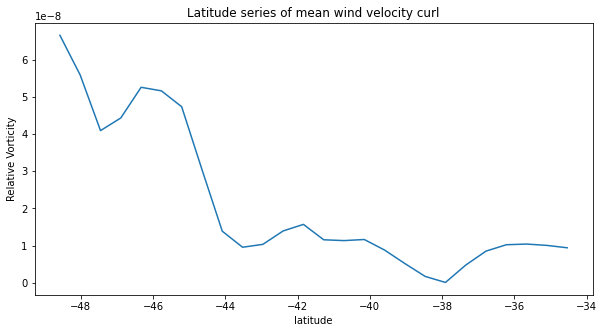

In [8]:
fig = plt.figure(figsize=(10, 5))
B1.sel(lon = 181, method = 'nearest').sel(lat=slice(-49,-34)).mean('time').plot()
plt.title('Latitude series of mean wind velocity curl');
plt.xlabel("latitude")
savefigure('map of wind stress curl')

In [13]:
%%time

a = []

for i, ekey in enumerate(data.keys()):

    print(ekey)

    e = data[ekey]

    # devide time interval
    b = []
    c = []

    dataset1 = pd.read_csv('3.2 IR_value/ir_NZ(1).csv')
    IR_NZ = dataset1.iloc[:, i+1].values

    for j, t in enumerate(range (58,119,1)):
        tstart = pd.to_datetime('1900/01/01') + pd.DateOffset(years=t)
        tend   = tstart + pd.DateOffset(years=1)
        print(str(tstart) +'-'+str(tend))

        c.append(str(tstart.year) +'-'+str(tend.year))


        # load data for each time interval
        expt = data[ekey]['expt']

        u = cc.querying.getvar(expt,'u',session,
                               frequency = '1 monthly',
                               start_time='1958-01-01 00:00:00', 
                               end_time='1958-03-01 00:00:00').isel(time=0).sel(st_ocean=0,method='nearest')
        tau_x = cc.querying.getvar(expt, variable='tau_x', 
                                  session=session, frequency='1 monthly',
                                  start_time=str(tstart.year), 
                                  end_time=str(tend.year)).sel(time=slice(tstart,tend)).mean('time').compute()
        tau_y = cc.querying.getvar(expt, variable='tau_y', 
                                  session=session, frequency='1 monthly',
                                  start_time=str(tstart.year), 
                                  end_time=str(tend.year)).sel(time=slice(tstart,tend)).mean('time').compute()

        lons = u.xu_ocean
        lats = u.yu_ocean


        if (i+1)%3 == 0:
            grid1 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dxt.nc', combine='by_coords')
            grid2 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dyt.nc', combine='by_coords')
            grid3 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dxu.nc', combine='by_coords')
            grid4 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dyu.nc', combine='by_coords')
            ds = xr.merge([tau_x, tau_y, grid1, grid2, grid3, grid4])

        else:
            grid = xr.open_mfdataset(folder[ekey], combine='by_coords')
            ds = xr.merge([tau_x, tau_y, grid])

        ds.coords['xt_ocean'].attrs.update(axis='X')
        ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
        ds.coords['yt_ocean'].attrs.update(axis='Y')
        ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

        grid = xgcm.Grid(ds, periodic=['X'])


        ζ_xgcm = (grid.interp( grid.diff(ds.tau_y, 'X') / grid.interp(ds.dxu, 'X'), 'X') 
             -  grid.interp( grid.diff(ds.tau_x, 'Y', boundary='extend') / grid.interp(ds.dyu, 'Y', boundary='extend'), 'Y', boundary='extend'))

        ζ_xgcm = ζ_xgcm.rename('Wind stress curl')
        ζ_xgcm.attrs['long_name'] = 'Wind stress curl, ∂τy/∂x-∂τx/∂y'
        ζ_xgcm.attrs['units'] = 'N m$^{-3}$'


        # land mask

        Aus1 = np.isnan(u).where(lons>=-248,other=False).where(lons<=-205,other=False).where(lats>=-45,other=False).where(lats<=3.5,other=False)
        Aus2 = Aus1.where(lons<=-231,other=False).where(lats>=-13,other=False)
        Aus3 = Aus1 & (~Aus2)
        Aus4 = Aus3.where(lons>=-216,True).where(lons<=-212,True).where(lats>=-41,True).where(lats<=-38,True)
        Aus5 = Aus3 | ~Aus4
        Aus6 = Aus5.where(lons>=-227,True).where(lons<=-216,True).where(lats>=-20,True).where(lats<=-4.3,True)
        Aus = Aus5 | (~Aus6)

        NZ = np.isnan(u).where(lons>=-196,other=False).where(lons<=-180,other=False).where(lats>=-49,other=False).where(lats<=-33,other=False)

        islands=[NZ, Aus | NZ]


        # Sverdrup transport

        ir_nz = IR_NZ[j]

        ST_value1 = Sverdrup_transport(ζ_xgcm)
        ST_value2 = Sverdrup_transport_T(ζ_xgcm)
        ST_value = ST_value1 + ST_value2
        b.append(ST_value)

    b = xr.concat(b, dim="time")
    c = np.array(c)
    b = b.assign_coords({'time': c})

    b.to_netcdf('Sverdrup_trans(1)' + e['desc'] + '.nc')

01deg_c2
1958-01-01 00:00:00-1959-01-01 00:00:00
1959-01-01 00:00:00-1960-01-01 00:00:00
1960-01-01 00:00:00-1961-01-01 00:00:00
1961-01-01 00:00:00-1962-01-01 00:00:00
1962-01-01 00:00:00-1963-01-01 00:00:00
1963-01-01 00:00:00-1964-01-01 00:00:00
1964-01-01 00:00:00-1965-01-01 00:00:00
1965-01-01 00:00:00-1966-01-01 00:00:00
1966-01-01 00:00:00-1967-01-01 00:00:00
1967-01-01 00:00:00-1968-01-01 00:00:00
1968-01-01 00:00:00-1969-01-01 00:00:00
1969-01-01 00:00:00-1970-01-01 00:00:00
1970-01-01 00:00:00-1971-01-01 00:00:00
1971-01-01 00:00:00-1972-01-01 00:00:00
1972-01-01 00:00:00-1973-01-01 00:00:00
1973-01-01 00:00:00-1974-01-01 00:00:00
1974-01-01 00:00:00-1975-01-01 00:00:00
1975-01-01 00:00:00-1976-01-01 00:00:00
1976-01-01 00:00:00-1977-01-01 00:00:00
1977-01-01 00:00:00-1978-01-01 00:00:00
1978-01-01 00:00:00-1979-01-01 00:00:00
1979-01-01 00:00:00-1980-01-01 00:00:00
1980-01-01 00:00:00-1981-01-01 00:00:00
1981-01-01 00:00:00-1982-01-01 00:00:00
1982-01-01 00:00:00-1983-01-01 

In [14]:
A1 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2_c1.nc')
A2 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-025_c1.nc')
A3 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-01_c1.nc')
A4 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2.nc')
A5 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-025.nc')
A6 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-01.nc')
A7 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2_c3.nc')
A8 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-025_c3.nc')
A9 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-01_c3.nc')
A = [A1,A2,A3,A4,A5,A6,A7,A8,A9]

In [15]:
c = []
for j, t in enumerate(range (58,119,1)):
    tstart = pd.to_datetime('1900/01/01') + pd.DateOffset(years=t)
    tend   = tstart + pd.DateOffset(years=1)
    print(str(tstart) +'-'+str(tend))

    c.append(str(tstart.year) +'-'+str(tend.year))

1958-01-01 00:00:00-1959-01-01 00:00:00
1959-01-01 00:00:00-1960-01-01 00:00:00
1960-01-01 00:00:00-1961-01-01 00:00:00
1961-01-01 00:00:00-1962-01-01 00:00:00
1962-01-01 00:00:00-1963-01-01 00:00:00
1963-01-01 00:00:00-1964-01-01 00:00:00
1964-01-01 00:00:00-1965-01-01 00:00:00
1965-01-01 00:00:00-1966-01-01 00:00:00
1966-01-01 00:00:00-1967-01-01 00:00:00
1967-01-01 00:00:00-1968-01-01 00:00:00
1968-01-01 00:00:00-1969-01-01 00:00:00
1969-01-01 00:00:00-1970-01-01 00:00:00
1970-01-01 00:00:00-1971-01-01 00:00:00
1971-01-01 00:00:00-1972-01-01 00:00:00
1972-01-01 00:00:00-1973-01-01 00:00:00
1973-01-01 00:00:00-1974-01-01 00:00:00
1974-01-01 00:00:00-1975-01-01 00:00:00
1975-01-01 00:00:00-1976-01-01 00:00:00
1976-01-01 00:00:00-1977-01-01 00:00:00
1977-01-01 00:00:00-1978-01-01 00:00:00
1978-01-01 00:00:00-1979-01-01 00:00:00
1979-01-01 00:00:00-1980-01-01 00:00:00
1980-01-01 00:00:00-1981-01-01 00:00:00
1981-01-01 00:00:00-1982-01-01 00:00:00
1982-01-01 00:00:00-1983-01-01 00:00:00


#### 特定位置处Sverdrup transport

In [16]:
a = []

for x in A:
    ST_value = x.sel(xu_ocean =-185, method = 'nearest').sel(yu_ocean = -36.5, method = 'nearest').values
    ST_value = np.around(ST_value,2)
    a.append(ST_value)
    
test=pd.DataFrame({'1deg_c1':a[0],'025deg_c1':a[1],'01deg_c1':a[2],
                   '1deg_c2':a[3],'025deg_c2':a[4],'01deg_c2':a[5],
                   '1deg_c3':a[6],'025deg_c3':a[7],'01deg_c3':a[8]})

test.index = c

print(test)

test.to_csv('Sverdrup_trans(1).csv')

           1deg_c1  025deg_c1  01deg_c1  1deg_c2  025deg_c2  01deg_c2  \
1958-1959   -24.42     -28.07    -28.07   -24.48     -27.47    -29.22   
1959-1960   -18.74     -21.77    -21.48   -19.01     -21.87    -23.51   
1960-1961   -22.61     -25.17    -24.68   -22.70     -25.65    -23.89   
1961-1962   -30.57     -32.07    -32.94   -30.54     -31.86    -33.40   
1962-1963   -24.26     -26.34    -26.35   -24.35     -26.11    -27.37   
...            ...        ...       ...      ...        ...       ...   
2014-2015   -19.50     -23.52    -22.83   -19.17     -21.96    -24.34   
2015-2016   -19.44     -20.20    -20.18   -19.04     -20.40    -20.79   
2016-2017   -30.13     -31.20    -33.46   -29.92     -31.64    -31.52   
2017-2018   -25.97     -25.38    -25.79   -25.85     -25.31    -25.26   
2018-2019   -26.21     -24.61    -27.83   -26.26     -24.66    -23.76   

           1deg_c3  025deg_c3  01deg_c3  
1958-1959   -24.46     -28.21    -27.34  
1959-1960   -18.92     -21.81    -21.46

### standard deviation of Sverdrup transport

In [15]:
%%time

for i, ekey in enumerate(data.keys()):
    print(ekey)
    
    e = data[ekey]
    
    # devide time interval
    b = []
    c = []
    
    dataset1 = pd.read_csv('3.2.IR_value/IR_NZ(10).csv')
    IR_NZ = dataset1.iloc[:, i+1].values
    
    for j, t in enumerate(range (58,109,10)):
        tstart = pd.to_datetime('1900/01/01') + pd.DateOffset(years=t)
        tend   = tstart + pd.DateOffset(years=10)
        print(str(tstart) +'-'+str(tend))
        
        c.append(str(tstart.year) +'-'+str(tend.year))
         
            
        # load data for each time interval
        expt = data[ekey]['expt']
        
        u = cc.querying.getvar(expt,'u',session,
                               frequency = '1 monthly',
                               start_time='1958-01-01 00:00:00', 
                               end_time='1958-03-01 00:00:00').isel(time=0).sel(st_ocean=0,method='nearest')
        tau_x = cc.querying.getvar(expt, variable='tau_x', 
                                  session=session, frequency='1 monthly',
                                  start_time=str(tstart.year), 
                                  end_time=str(tend.year)).sel(time=slice(tstart,tend))
        tau_y = cc.querying.getvar(expt, variable='tau_y', 
                                  session=session, frequency='1 monthly',
                                  start_time=str(tstart.year), 
                                  end_time=str(tend.year)).sel(time=slice(tstart,tend))
        
        lons = u.xu_ocean
        lats = u.yu_ocean
        
        
        if (i+1)%3 == 0:
            grid1 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dxt.nc', combine='by_coords')
            grid2 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dyt.nc', combine='by_coords')
            grid3 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dxu.nc', combine='by_coords')
            grid4 = xr.open_mfdataset(folder[ekey]+'ocean-2d-dyu.nc', combine='by_coords')
            ds = xr.merge([tau_x, tau_y, grid1, grid2, grid3, grid4])

        else:
            grid = xr.open_mfdataset(folder[ekey], combine='by_coords')
            ds = xr.merge([tau_x, tau_y, grid])
            
        ds.coords['xt_ocean'].attrs.update(axis='X')
        ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
        ds.coords['yt_ocean'].attrs.update(axis='Y')
        ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
        
        grid = xgcm.Grid(ds, periodic=['X'])
        
        
        # ζ_xgcm = ( grid.interp( grid.diff(ds.tau_y, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
        #   - grid.interp( grid.diff(ds.tau_x, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )
        
        ζ_xgcm = (grid.interp( grid.diff(ds.tau_y, 'X') / grid.interp(ds.dxu, 'X'), 'X') 
             -  grid.interp( grid.diff(ds.tau_x, 'Y', boundary='extend') / grid.interp(ds.dyu, 'Y', boundary='extend'), 'Y', boundary='extend'))

        ζ_xgcm = ζ_xgcm.rename('Wind stress curl')
        ζ_xgcm.attrs['long_name'] = 'Wind stress curl, ∂τy/∂x-∂τx/∂y'
        ζ_xgcm.attrs['units'] = 'N m$^{-3}$'
        
        
        # land mask
    
        Aus1 = np.isnan(u).where(lons>=-248,other=False).where(lons<=-205,other=False).where(lats>=-45,other=False).where(lats<=3.5,other=False)
        Aus2 = Aus1.where(lons<=-231,other=False).where(lats>=-13,other=False)
        Aus3 = Aus1 & (~Aus2)
        Aus4 = Aus3.where(lons>=-216,True).where(lons<=-212,True).where(lats>=-41,True).where(lats<=-38,True)
        Aus5 = Aus3 | ~Aus4
        Aus6 = Aus5.where(lons>=-227,True).where(lons<=-216,True).where(lats>=-20,True).where(lats<=-4.3,True)
        Aus = Aus5 | (~Aus6)

        NZ = np.isnan(u).where(lons>=-196,other=False).where(lons<=-180,other=False).where(lats>=-49,other=False).where(lats<=-33,other=False)

        islands=[NZ, Aus | NZ]
        
         
        # Sverdrup transport
        
        ir_nz = IR_NZ[j]
        
        ST_value1 = Sverdrup_transport(ζ_xgcm)
        ST_value2 = Sverdrup_transport_T(ζ_xgcm)
        ST_value = ST_value1 + ST_value2
        
        ST_value_sq = ST_value**2       
        ST_value_m = ST_value.mean('time')
        ST_value_sq_m = ST_value_sq.mean('time')
        ST_value_std = (ST_value_sq_m - (ST_value_m)**2)**0.5
    
        b.append(ST_value_std)
        
        
    b = xr.concat(b, dim="time")
    c = np.array(c)
    b = b.assign_coords({'time': c})
    
    b.to_netcdf('Sverdrup_trans_std(10)' + e['desc'] + '.nc')

1deg_c1
1958-01-01 00:00:00-1968-01-01 00:00:00
1968-01-01 00:00:00-1978-01-01 00:00:00
1978-01-01 00:00:00-1988-01-01 00:00:00
1988-01-01 00:00:00-1998-01-01 00:00:00
1998-01-01 00:00:00-2008-01-01 00:00:00
2008-01-01 00:00:00-2018-01-01 00:00:00


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


025deg_c1
1958-01-01 00:00:00-1968-01-01 00:00:00
1968-01-01 00:00:00-1978-01-01 00:00:00
1978-01-01 00:00:00-1988-01-01 00:00:00
1988-01-01 00:00:00-1998-01-01 00:00:00
1998-01-01 00:00:00-2008-01-01 00:00:00
2008-01-01 00:00:00-2018-01-01 00:00:00


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


01deg_c1
1958-01-01 00:00:00-1968-01-01 00:00:00


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


1968-01-01 00:00:00-1978-01-01 00:00:00


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1978-01-01 00:00:00-1988-01-01 00:00:00
1988-01-01 00:00:00-1998-01-01 00:00:00
1998-01-01 00:00:00-2008-01-01 00:00:00
2008-01-01 00:00:00-2018-01-01 00:00:00


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


1deg_c2
1958-01-01 00:00:00-1968-01-01 00:00:00
1968-01-01 00:00:00-1978-01-01 00:00:00
1978-01-01 00:00:00-1988-01-01 00:00:00
1988-01-01 00:00:00-1998-01-01 00:00:00
1998-01-01 00:00:00-2008-01-01 00:00:00
2008-01-01 00:00:00-2018-01-01 00:00:00


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


025deg_c2
1958-01-01 00:00:00-1968-01-01 00:00:00
1968-01-01 00:00:00-1978-01-01 00:00:00
1978-01-01 00:00:00-1988-01-01 00:00:00
1988-01-01 00:00:00-1998-01-01 00:00:00
1998-01-01 00:00:00-2008-01-01 00:00:00
2008-01-01 00:00:00-2018-01-01 00:00:00


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

01deg_c2
1958-01-01 00:00:00-1968-01-01 00:00:00


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1968-01-01 00:00:00-1978-01-01 00:00:00


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1978-01-01 00:00:00-1988-01-01 00:00:00
1988-01-01 00:00:00-1998-01-01 00:00:00
1998-01-01 00:00:00-2008-01-01 00:00:00
2008-01-01 00:00:00-2018-01-01 00:00:00


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


1deg_c3
1958-01-01 00:00:00-1968-01-01 00:00:00
1968-01-01 00:00:00-1978-01-01 00:00:00
1978-01-01 00:00:00-1988-01-01 00:00:00
1988-01-01 00:00:00-1998-01-01 00:00:00
1998-01-01 00:00:00-2008-01-01 00:00:00
2008-01-01 00:00:00-2018-01-01 00:00:00


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


025deg_c3
1958-01-01 00:00:00-1968-01-01 00:00:00
1968-01-01 00:00:00-1978-01-01 00:00:00
1978-01-01 00:00:00-1988-01-01 00:00:00
1988-01-01 00:00:00-1998-01-01 00:00:00
1998-01-01 00:00:00-2008-01-01 00:00:00
2008-01-01 00:00:00-2018-01-01 00:00:00


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

01deg_c3
1958-01-01 00:00:00-1968-01-01 00:00:00


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


1968-01-01 00:00:00-1978-01-01 00:00:00


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1978-01-01 00:00:00-1988-01-01 00:00:00


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1988-01-01 00:00:00-1998-01-01 00:00:00
1998-01-01 00:00:00-2008-01-01 00:00:00
2008-01-01 00:00:00-2018-01-01 00:00:00


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 1h 27min 15s, sys: 2min 2s, total: 1h 29min 17s
Wall time: 1h 32min 8s


### Sverdrup tranport at different latitude 

In [4]:
A1 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2_c1.nc')
A2 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-025_c1.nc')
A3 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-01_c1.nc')
A4 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2.nc')
A5 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-025.nc')
A6 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-01.nc')
A7 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2_c3.nc')
A8 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-025_c3.nc')
A9 = xr.open_dataarray('Sverdrup_trans(1)ACCESS-OM2-01_c3.nc')

In [31]:
A6.sel(xu_ocean=-206.5, method='nearest').sel(yu_ocean=-28 ,method='nearest').mean('time').values

array(-31.00061092)

In [15]:
A6.sel(xu_ocean=-205.2, method='nearest').sel(yu_ocean=-28 ,method='nearest').mean('time').values

array(-30.39491723)

In [16]:
A6.sel(xu_ocean=-187, method='nearest').sel(yu_ocean=-28 ,method='nearest').mean('time').values

array(-25.40926706)

In [17]:
A6.sel(xu_ocean=-212.5, method='nearest').sel(yu_ocean=-43.5 ,method='nearest').mean('time').values

array(-25.98531369)

In [18]:
A6.sel(xu_ocean=-210.2, method='nearest').sel(yu_ocean=-43.5 ,method='nearest').mean('time').values

array(-22.23569873)

In [29]:
A6.sel(xu_ocean=-189, method='nearest').sel(yu_ocean=-43.5 ,method='nearest').mean('time').values

array(-26.48898346)

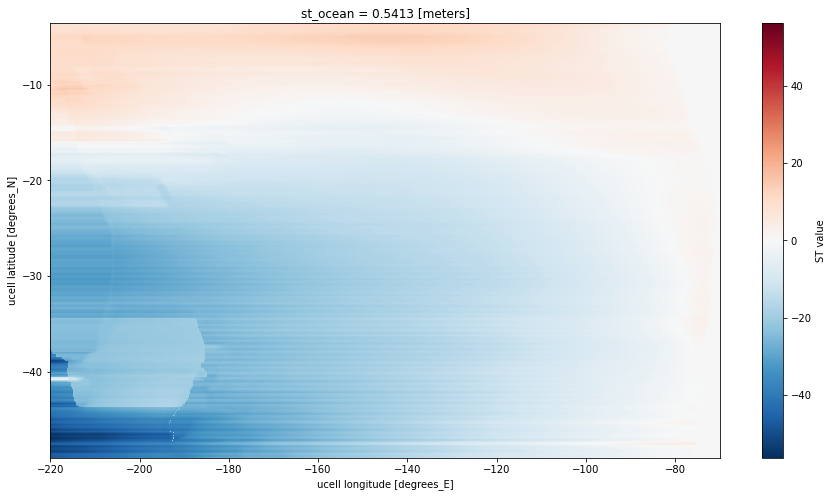

In [5]:
A6.mean('time').plot(figsize = (15,8))
# savefigure('1')

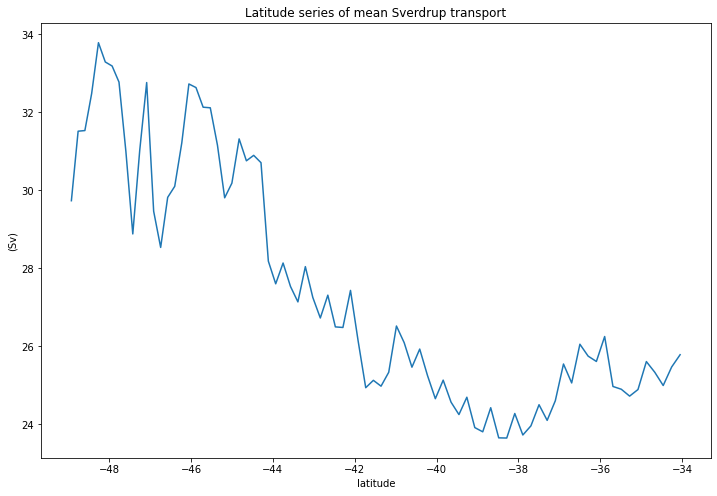

In [40]:
plt.figure(figsize(12,8))
(A5*(-1)).sel(xu_ocean =-181, method = 'nearest').sel(yu_ocean=slice(-49,-34)).mean('time').plot()
plt.title('Latitude series of mean Sverdrup transport')
plt.xlabel('latitude')
plt.ylabel('(Sv)')
    
savefigure('ST-IR value')